## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import time

## Load Data

In [2]:
df_train_base = pd.read_csv("train.csv")
df_test_base = pd.read_csv("test.csv")

In [3]:
df_train = df_train_base
df_test = df_test_base

## Data Processing

In [4]:
df_train.isna().sum().apply(lambda col: str(round(col/len(df_train), 2)*100) + " %")

Dates         0.0 %
Category      0.0 %
Descript      0.0 %
DayOfWeek     0.0 %
PdDistrict    0.0 %
Resolution    0.0 %
Address       0.0 %
X             0.0 %
Y             0.0 %
dtype: object

In [5]:
df_test.isna().sum().apply(lambda col: str(round(col/len(df_test), 2)*100) + " %")

Id            0.0 %
Dates         0.0 %
DayOfWeek     0.0 %
PdDistrict    0.0 %
Address       0.0 %
X             0.0 %
Y             0.0 %
dtype: object

## Date

- Convertir Date en Year / Month / Day / Hour / Minute / Second

In [6]:
df_train=pd.read_csv('train.csv',parse_dates=['Dates'])
df_test=pd.read_csv('test.csv',parse_dates=['Dates'])

In [7]:
df_train['Year']=df_train['Dates'].dt.year
df_test['Year']=df_test['Dates'].dt.year

In [8]:
df_train['Month']=df_train['Dates'].dt.month
df_test['Month']=df_test['Dates'].dt.month

In [9]:
df_train['Day']=df_train['Dates'].dt.day
df_test['Day']=df_test['Dates'].dt.day

In [10]:
df_train['Hour']=df_train['Dates'].dt.hour
df_test['Hour']=df_test['Dates'].dt.hour

In [11]:
df_train['Minute']=df_train['Dates'].dt.minute
df_test['Minute']=df_test['Dates'].dt.minute

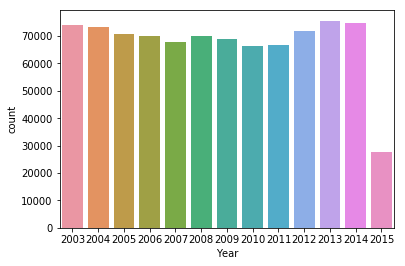

In [12]:
sns.countplot(data=df_train, x='Year')

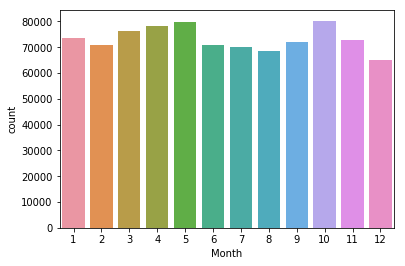

In [13]:
sns.countplot(data=df_train, x='Month')

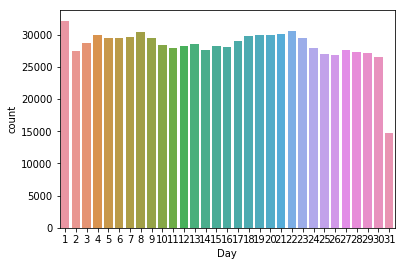

In [14]:
sns.countplot(data=df_train, x='Day')

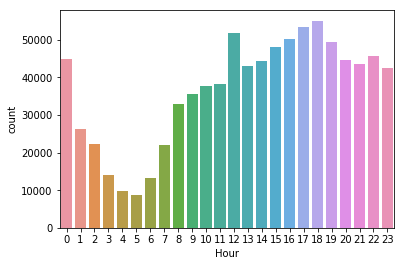

In [15]:
sns.countplot(data=df_train, x='Hour')

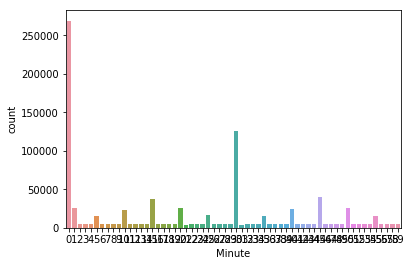

In [16]:
sns.countplot(data=df_train, x='Minute')

- Convertir les minutes =30 en minutes = 0 car 30 trop haut comparé aux autres 
- Seconde et Minute => On s'en fou mais minute = 30 est trop élevé /
- Heure => Pas trop de crime de 1h à 7h du matin /
- Jour => Moins de crime le 31 car pas présent tous les mois /
- Année => 2015 pauvre en données

In [17]:
df_train.loc[df_train['Minute'] == 30, 'Minute'] = 0
df_test.loc[df_test['Minute'] == 30, 'Minute'] = 0

In [18]:
def horaire_bin(hour):
    if hour >=8 & hour ==0:
        return '1'
    else:
        return '0'

In [19]:
df_train['horaire_bin'] = df_train['Hour'].apply(lambda x:horaire_bin(x))
df_test['horaire_bin'] = df_test['Hour'].apply(lambda x:horaire_bin(x))

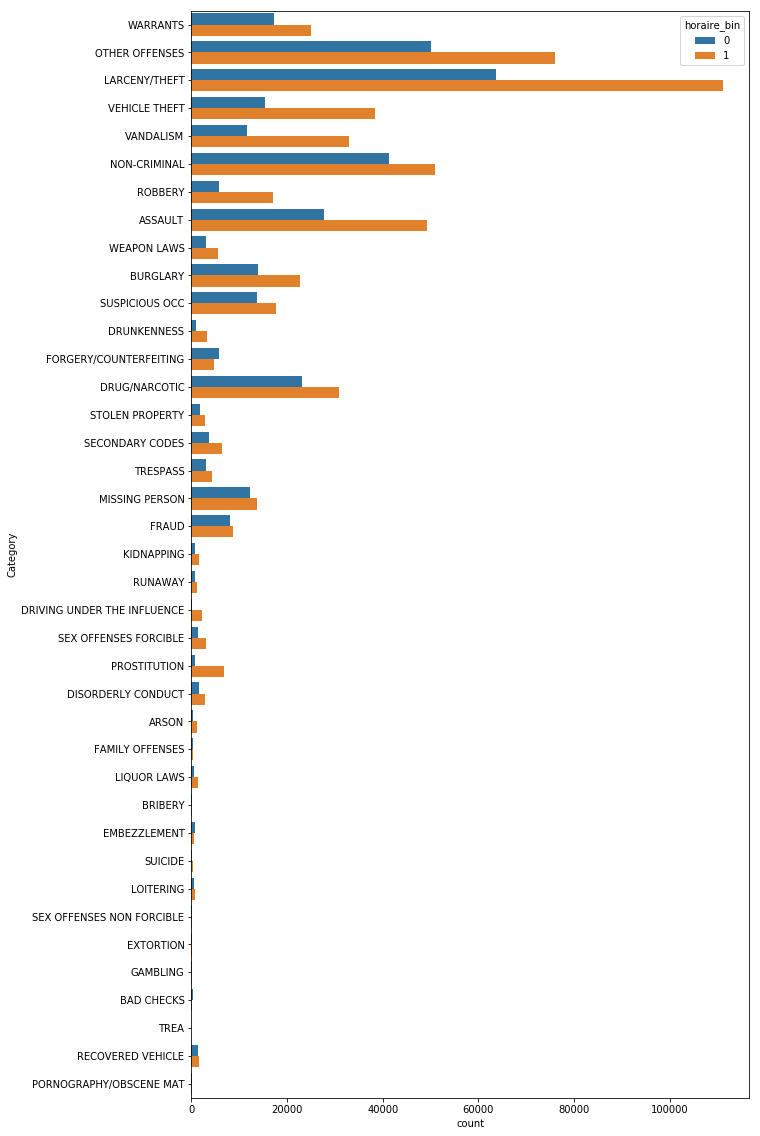

In [ ]:
fig, taille = plt.subplots(figsize=(10,20))
sns.countplot(data=df_train, y='Category', hue='horaire_bin', ax=taille)

On remarque que les catégories de crime sont similaire

## DayOfWeek

In [ ]:
df_dayofweek_processed = df_train
df_dayofweek_processed_test = df_test

In [ ]:
ohe_cols_dayofweek = pd.get_dummies(df_dayofweek_processed['DayOfWeek'], prefix='Day')
ohe_cols_dayofweek_test = pd.get_dummies(df_dayofweek_processed_test['DayOfWeek'], prefix='Day')

In [ ]:
ohe_df_dayofweek = pd.concat([
    df_dayofweek_processed.drop(columns=['DayOfWeek']),
    ohe_cols_dayofweek
], axis=1)

ohe_df_dayofweek_test = pd.concat([
    df_dayofweek_processed_test.drop(columns=['DayOfWeek']),
    ohe_cols_dayofweek_test
], axis=1)

In [ ]:
ohe_cols_dayofweek_list = list(ohe_cols_dayofweek.columns)

## PdDistrict

In [ ]:
df_train.groupby('PdDistrict')['PdDistrict'].count()

PdDistrict
BAYVIEW        89431
CENTRAL        85460
INGLESIDE      78845
MISSION       119908
NORTHERN      105296
PARK           49313
RICHMOND       45209
SOUTHERN      157182
TARAVAL        65596
TENDERLOIN     81809
Name: PdDistrict, dtype: int64

In [ ]:
df_pddistrict_processed = ohe_df_dayofweek
df_pddistrict_processed_test = ohe_df_dayofweek_test

In [ ]:
ohe_cols_pddistrict = pd.get_dummies(df_pddistrict_processed['PdDistrict'], prefix='District')
ohe_cols_pddistrict_test = pd.get_dummies(df_pddistrict_processed_test['PdDistrict'], prefix='District')

In [ ]:
ohe_df_pddistrict = pd.concat([
    df_pddistrict_processed.drop(columns=['PdDistrict']),
    ohe_cols_pddistrict
], axis=1)

ohe_df_pddistrict_test = pd.concat([
    df_pddistrict_processed_test.drop(columns=['PdDistrict']),
    ohe_cols_pddistrict_test
], axis=1)

In [ ]:
ohe_cols_pddistrict_list = list(ohe_cols_pddistrict.columns)

## Address

1) Une colonne pour différencier les rue et les block en splitant sur "/" et mettre "street" ou "block"
2) Récupérer seulement les adresses street
3) Récupérer les adresses street unique
4) Faire un reverse sur certaines adresses street, exemple => 'JONES ST / TURK ST' == 'TURK ST / JONES ST'
5) Remplacer les adresses qui ont été reverse

In [ ]:
df_address_processed = ohe_df_pddistrict
df_address_processed_test = ohe_df_pddistrict_test

In [ ]:
def adresse_bin(address):
    if '/' in address:
        return '0'
    else:
        return '1'

In [ ]:
df_address_processed['Address_type'] = df_address_processed['Address'].apply(lambda x:adresse_bin(x))
df_address_processed_test['Address_type'] = df_address_processed_test['Address'].apply(lambda x:adresse_bin(x))

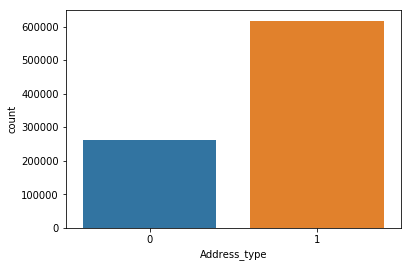

In [ ]:
sns.countplot(data=df_address_processed, x='Address_type')

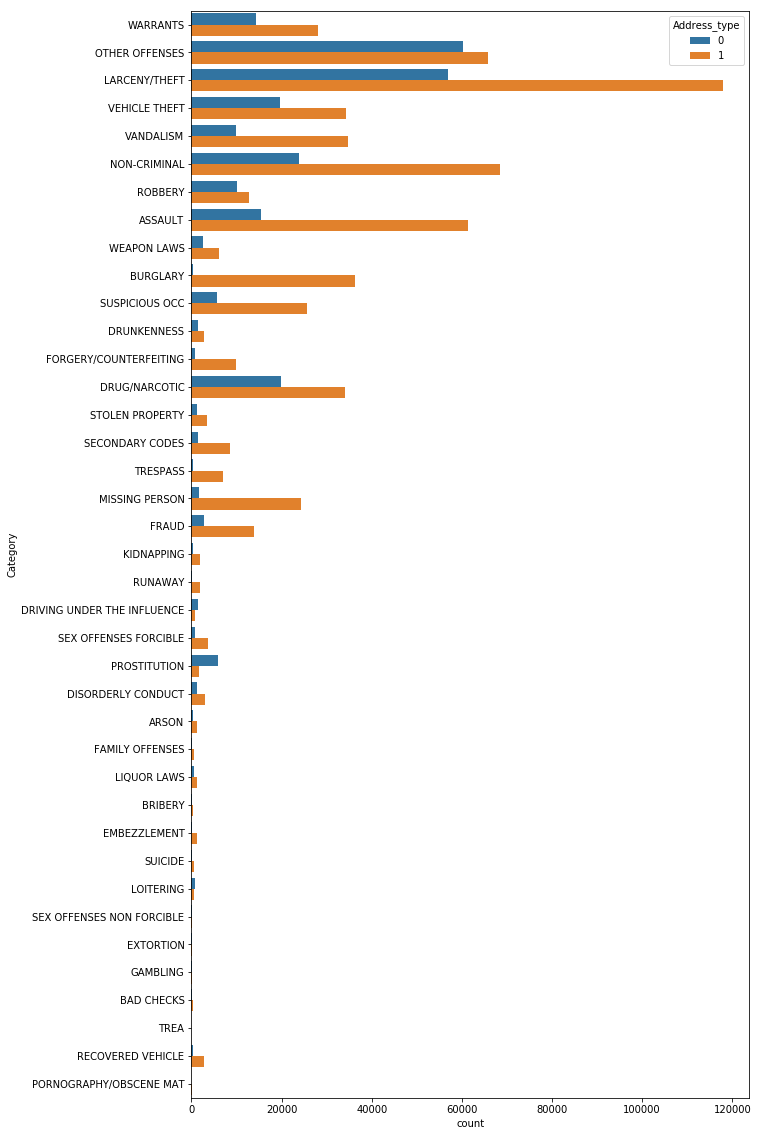

In [ ]:
fig, taille = plt.subplots(figsize=(10,20))
sns.countplot(data=df_address_processed, y='Category', hue='Address_type', ax=taille)

In [ ]:
top100_address = df_address_processed['Address'].value_counts()
top100_address = top100_address[top100_address >=100]
top100_address = top100_address.index

In [ ]:
df_address_processed['Address_top100'] = df_address_processed['Address']
df_address_processed.loc[~df_address_processed['Address'].isin(top100_address), "Address_top100"] = 'Autre'

df_address_processed_test['Address_top100'] = df_address_processed_test['Address']
df_address_processed_test.loc[~df_address_processed_test['Address'].isin(top100_address), "Address_top100"] = 'Autre'

In [ ]:
reverse_address = df_address_processed[df_address_processed['Address_top100'].str.contains('/')]
reverse_address_list = reverse_address['Address_top100'].unique()

reverse_address_test = df_address_processed_test[df_address_processed_test['Address_top100'].str.contains('/')]
reverse_address_list_test = reverse_address_test['Address_top100'].unique()

In [ ]:
for address in reverse_address_list:
    address_split = address.split("/")
    reverse = address_split[1].strip() + " / " + address_split[0].strip()
    
    df_address_processed.loc[df_address_processed["Address_top100"] == reverse, "Address_top100"] = address
    df_address_processed_test.loc[df_address_processed_test["Address_top100"] == reverse, "Address_top100"] = address

In [ ]:
df_address_processed.head(2)

,Dates,Category,Descript,Resolution,Address,X,Y,Year,Month,Day,...,District_INGLESIDE,District_MISSION,District_NORTHERN,District_PARK,District_RICHMOND,District_SOUTHERN,District_TARAVAL,District_TENDERLOIN,Address_type,Address_top100
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,...,0,0,1,0,0,0,0,0,0,Autre
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,...,0,0,1,0,0,0,0,0,0,Autre


## Submission

In [ ]:
df_train_sub = df_address_processed
df_test_sub = df_address_processed_test
pd.set_option('display.max_columns', 50)
df_train_sub.head(2)

,Dates,Category,Descript,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute,horaire_bin,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,District_BAYVIEW,District_CENTRAL,District_INGLESIDE,District_MISSION,District_NORTHERN,District_PARK,District_RICHMOND,District_SOUTHERN,District_TARAVAL,District_TENDERLOIN,Address_type,Address_top100
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,Autre
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,Autre


In [ ]:
feature_names = ['X', 'Y', 'Address_type', 'Minute', 'Hour', 'horaire_bin', 'Day', 'Year', 'Month']
feature_names = feature_names + ohe_cols_pddistrict_list + ohe_cols_dayofweek_list
label_name = 'Category'
X_train = df_train_sub[feature_names]
y_train = df_train_sub[label_name]

In [ ]:
X_test = df_test_sub[feature_names]

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
label_encoder.fit(df_train_sub["Address_top100"])

LabelEncoder()

In [ ]:
df_train_sub["Address_top100_encode"] = label_encoder.transform(df_train_sub["Address_top100"])
df_test_sub["Address_top100_encode"] = label_encoder.transform(df_test_sub["Address_top100"])

In [ ]:
one_hot_encoder = OneHotEncoder()

In [ ]:
one_hot_encoder.fit(df_train_sub[["Address_top100_encode"]])

C:\Users\thomas\AppData\Local\Continuum\anaconda3\envs\majeure-ml-env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [ ]:
train_address = one_hot_encoder.transform(df_train_sub[["Address_top100_encode"]])
test_address = one_hot_encoder.transform(df_test_sub[["Address_top100_encode"]])

In [ ]:
X_train = hstack((X_train.astype(np.float32), train_address))
X_test = hstack((X_test.astype(np.float32), test_address))

In [ ]:
model = xgb.XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=16,
                          max_delta_step=1,
                          nthread=-1,
                          n_jobs = -1,
                          verbose = 1)

In [ ]:
%time score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=5).mean()
score   

In [ ]:
model.fit(X_train, y_train)

In [ ]:
preds = model.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame(preds, columns=model.classes_)

In [ ]:
submission.to_csv('submission.csv', index=True, index_label='Id')

# Features non utilisé

## K Means

Utilisé sur les X et Y, nous trouvons un K Means avec 10 clusters grâce à la méthode d'Elbow

## Random Forest

In [ ]:
Bon résultat mais légèrement inférieur au xgboost donc préférence pour ce dernier

## Distance entre lieu de crime et commissariat

In [ ]:
Feature utilisé mais perte de 0.01 sur le score final

## Moments de la journée

Découpage de la journée en 4 catégorie car suivant les crimes l'heure est différente

## Street

Colonne avec seulement le nom des street mais pas intéressant pour le modèle